In [1]:
'''
Trabalho de Economia Monetária – Exame 2

Autor: Luiz Filipe de Almeida Xavier

'''

'\nTrabalho de Economia Monetária – Exame 2\n\nAutor: Luiz Filipe de Almeida Xavier\n\n'

In [3]:
#Instalando as bibliotecas
!pip install matplotlib

In [5]:
!pip install pandas 1.3.6

ERROR: Could not find a version that satisfies the requirement 1.3.6 (from versions: none)
ERROR: No matching distribution found for 1.3.6


In [6]:
!pip install ipeadatapy

In [7]:
!pip install scikit-learn

In [8]:
!pip install statsmodels

In [9]:
!pip install numpy

In [10]:
!pip install python-bcb

In [11]:
!pip install yfinance

In [12]:
#Importando bibliotecas
import ipeadatapy as ipea
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
from bcb import Expectativas
from bcb import sgs
import yfinance as yf

C:\Users\Luiz Filipe\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
'''RESULTADOS PARA A PERGUNTA 1 Análise das Curvas de Oferta e Demanda Agregada no Brasil'''

In [13]:
#criando função para puxar os dados do ipeadata
def serie_variavel(variavel, nome, coluna):
    #listando as series com a variável
    lista_series = ipea.list_series(variavel)
    
    #pegando o código da serie temporal específica
    codigo = lista_series.loc[lista_series["NAME"] == nome, 'CODE'].iloc[0]
    
    #selecionando a serie temporal de acordo com o código
    var_ts = ipea.timeseries(codigo)
    
    #retirando possíveis espaços nas colunas
    var_ts.columns = var_ts.columns.str.strip()
    
    #selecionando apenas os valores trimestrais da serie temporal
    var_tri = var_ts[[coluna]]
    return var_tri

In [14]:
#selecionando as séries temporais: PIB e Inflação
#PIB
nome_pib = "PIB - preços de mercado - índice real encadeado dessazonalizado (média 1995 = 100)"
pib = serie_variavel('PIB', nome_pib, "VALUE (-)")
pib.columns = ["TRIMESTRAL PIB"]

#INFLAÇÃO
nome_ipca = "IPCA - núcleo médias aparadas com suavização - taxa de variação"
ipca_mensal = serie_variavel('IPCA', nome_ipca, 'VALUE ((% a.m.))')

#transformando dados para acumulado trimestral
ipca = pd.DataFrame(dtype='object')
trimestres = []
for i in range(0, len(ipca_mensal)-3,3):

    soma_trimestre = ipca_mensal.iloc[i] + ipca_mensal.iloc[i+1] + ipca_mensal.iloc[i+2]
    ipca = pd.concat([ipca, soma_trimestre])
    trimestres.append(ipca_mensal.index[i])

ipca.index = trimestres
ipca.index.name = "DATE"
ipca.columns = ["%TRIMESTRAL ACUMULADO IPCA"]

In [15]:
#pegando cada componente da demanda agregada
#Y = C + I + G + X - M

#CONSUMO
nome_consumo = "PIB - consumo final - famílias - índice real encadeado dessazonalizado (média 1995 = 100)"
consumo = serie_variavel('PIB', nome_consumo, "VALUE (-)")
consumo.rename(columns={"VALUE (-)":'C'}, inplace=True) 

#INVESTIMENTO
nome_investimento = "PIB - formação bruta de capital fixo - índice real encadeado dessazonalizado (média 1995 = 100)"
investimento = serie_variavel('PIB', nome_investimento, "VALUE (-)")
investimento.rename(columns={"VALUE (-)":'I'}, inplace=True) 

#GASTO DO GOVERNO
nome_gasto = "PIB - consumo final - APU"
gasto = serie_variavel('PIB', nome_gasto, "VALUE (R$)")
gasto.rename(columns={"VALUE (R$)":'G'}, inplace=True) 

#EXPORTAÇÃO
nome_exportacao = "PIB - exportações - bens e serviços - índice real encadeado dessazonalizado (média 1995 = 100)"
exportacao = serie_variavel('PIB', nome_exportacao, "VALUE (-)")
exportacao.rename(columns={"VALUE (-)":'X'}, inplace=True) 

#IMPORTACAO
nome_importacao = "PIB - importações - bens e serviços - índice real encadeado dessazonalizado (média 1995 = 100)"
importacao = serie_variavel('PIB', nome_importacao, "VALUE (-)")
importacao.rename(columns={"VALUE (-)":'M'}, inplace=True) 

In [16]:
#juntando dados para o mesmo período
componentes_pib = pib.merge(consumo, on='DATE') \
               .merge(gasto, on='DATE') \
               .merge(investimento, on='DATE') \
               .merge(exportacao, on='DATE') \
               .merge(importacao, on='DATE')

ln_componentes_pib = np.log(componentes_pib)

In [17]:
#pegando o componente cíclico e tendências dos componentes do PIB
ciclos = ln_componentes_pib.copy()
tendencias = componentes_pib.copy()
for componente in ln_componentes_pib:
    ciclos[componente] = sm.tsa.filters.hpfilter(ln_componentes_pib[componente], lamb=6.25)[0]
    
for componente in componentes_pib:
    tendencias[componente] = sm.tsa.filters.hpfilter(componentes_pib[componente], lamb=6.25)[1]

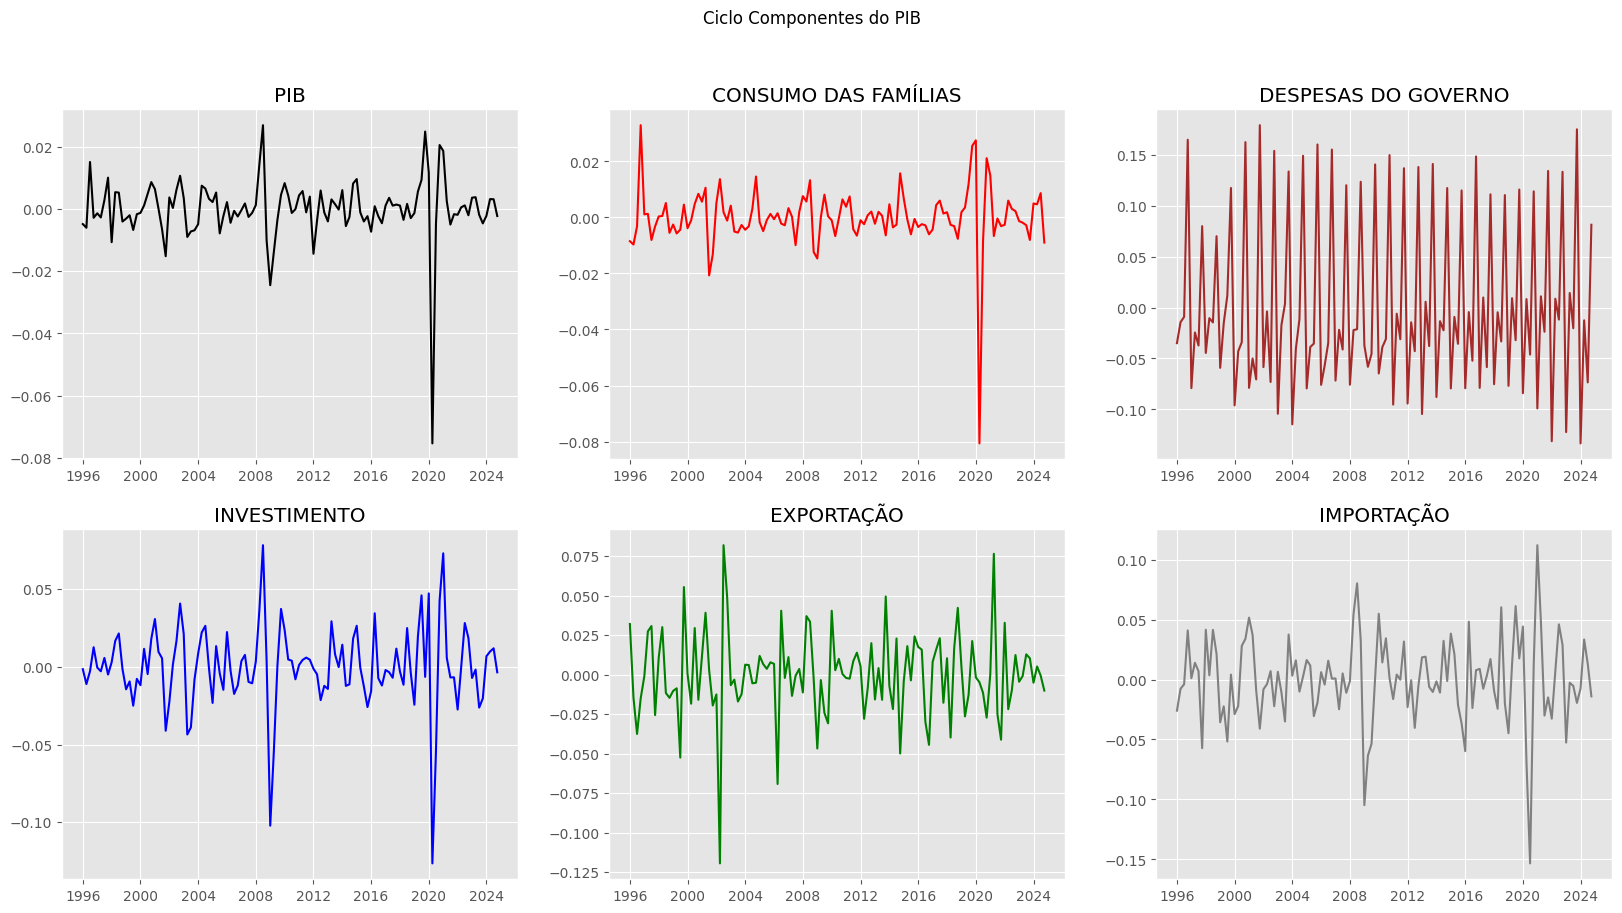

In [18]:
#plotando gráficos dos ciclos dos componentes da demanda agregada
nomes = {'TRIMESTRAL PIB': 'PIB','C':'CONSUMO DAS FAMÍLIAS','G':'DESPESAS DO GOVERNO','I':'INVESTIMENTO','X':'EXPORTAÇÃO','M':'IMPORTAÇÃO'}
cores ={'TRIMESTRAL PIB': 'black','C':'red','G':'brown','I':'blue','X':'green','M':'gray'}
plt.style.use("ggplot")
axs = list()
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
axi = 0
for componente in ciclos:
    axs[axi].plot(ciclos.index,ciclos[componente], linestyle='-', color=cores[componente])
    axs[axi].set_title(nomes[componente])
    axi += 1
    
plt.suptitle('Ciclo Componentes do PIB')
plt.show()

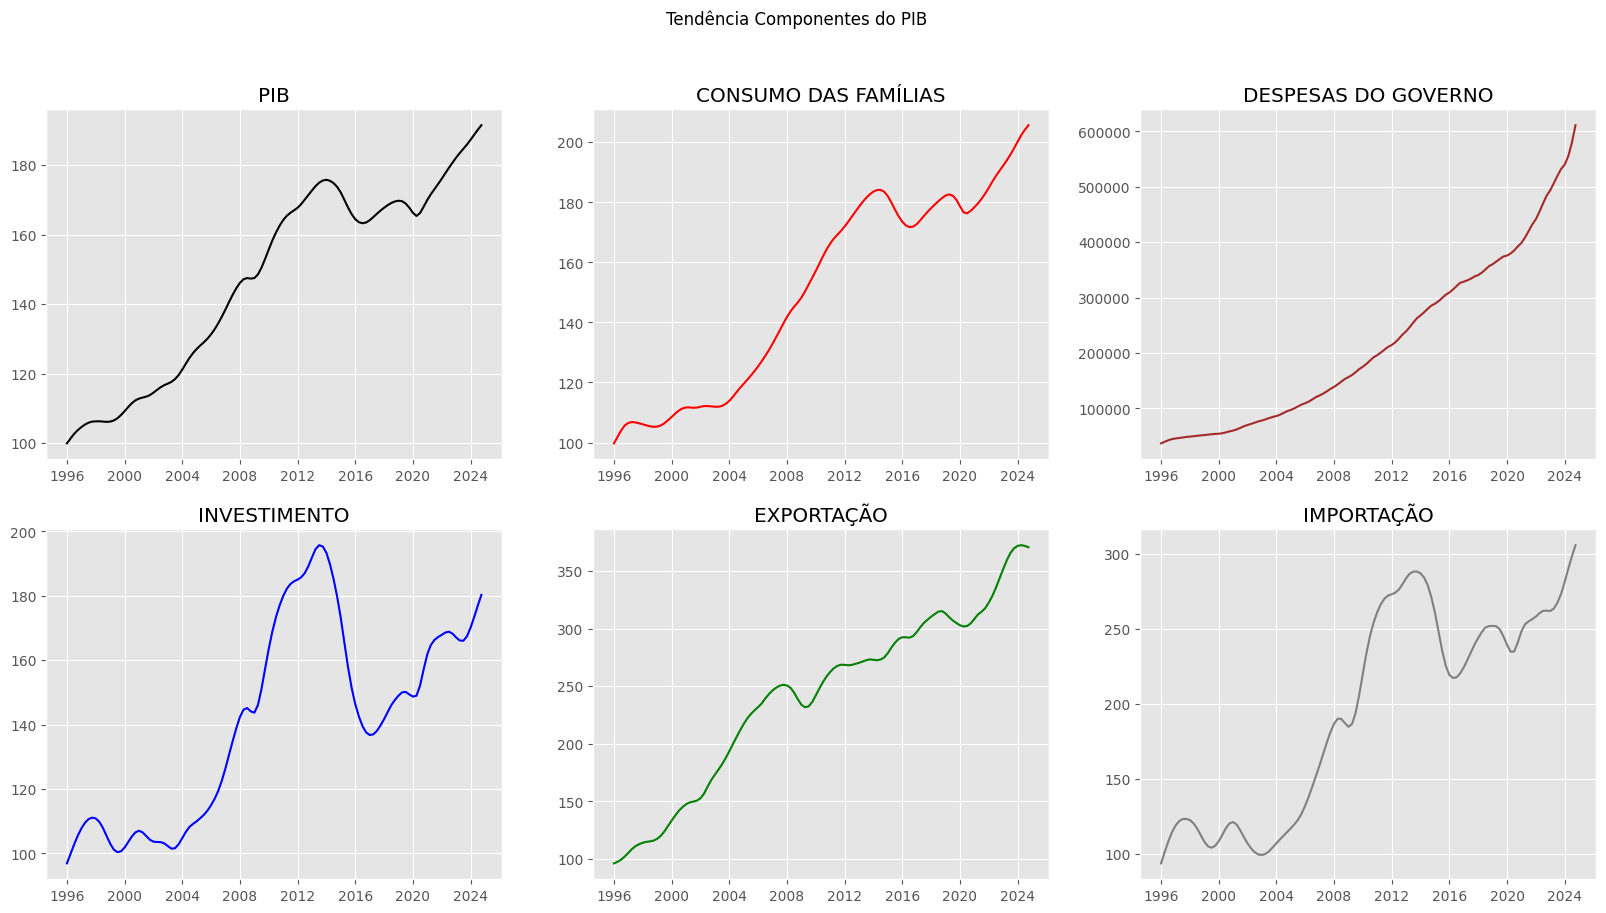

In [19]:
#plotando gráficos de tendências dos componentes da demanda agregada
plt.style.use("ggplot")
axs = list()
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
axi = 0
for componente in tendencias:
    axs[axi].plot(tendencias.index,tendencias[componente], linestyle='-', color=cores[componente])
    axs[axi].set_title(nomes[componente])
    axi += 1
    
plt.suptitle('Tendência Componentes do PIB')
plt.show()

In [29]:
#pegando componentes da oferta agregada

#desemprego mensal
desemprego_mensal = serie_variavel('desemprego', 'Taxa de desemprego (desocupação)', 'VALUE ((%))')

desemprego_mensal['media'] = np.mean(desemprego_mensal)

#inflação (a partir do mesmo ano que os dados do desemprego)
nome_var_ipca = 'IPCA - taxa de variação'
var_ipca_total = serie_variavel('IPCA', nome_var_ipca, 'VALUE ((% a.a.))')
var_ipca = var_ipca_total.copy().tail(25-12)
var_ipca['media'] = np.mean(var_ipca['VALUE ((% a.a.))'])

#pegando os dados da variação do ipca anual
nome_ipca_anual = 'IPCA - taxa de variação'
ipca_anual = serie_variavel('IPCA', nome_ipca_anual, 'VALUE ((% a.a.))')

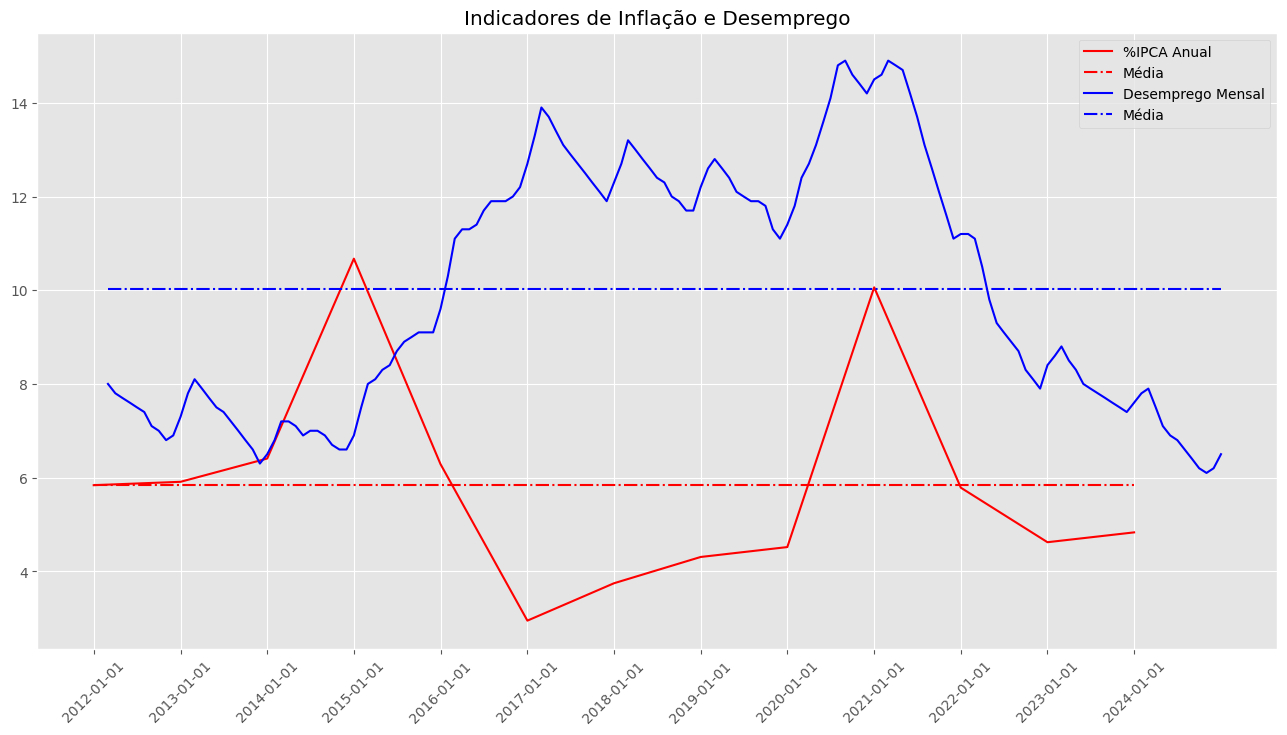

In [30]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
#inflação
plt.plot(var_ipca['VALUE ((% a.a.))'], linestyle='-', label='%IPCA Anual', color="red")
plt.plot(var_ipca.index,var_ipca['media'], linestyle='-.', label='Média', color="red")

#desemprego
plt.plot(desemprego_mensal['VALUE ((%))'], linestyle='-', label='Desemprego Mensal', color="blue")
plt.plot(desemprego_mensal['media'], linestyle='-.', label='Média', color="blue")
plt.title('Indicadores de Inflação e Desemprego')
plt.xticks(var_ipca.index, rotation=45)
plt.legend()
plt.show()

In [31]:
#pegando os dados da taxa de juros SELIC 
nome_selic = 'Taxa de juros - Selic - fixada pelo Copom'
selic_diaria = serie_variavel('Taxa de juros', nome_selic, 'VALUE ((% a.a.))')

#filtrando as taxas nos mesmos períodos do IPCA
selic = (ipca_mensal.join(selic_diaria, on='DATE')).drop(columns='VALUE ((% a.m.))')

#pegando os dados do PIB sazonalizado (utilizado para divulgar o crescimento na página oficial do IBGE)
nome_pib_saz = 'PIB - preços de mercado - índice real encadeado (média 1995 = 100)'
pib_sazonalizado = serie_variavel('PIB', nome_pib_saz, 'VALUE (-)')

#montando tabela de crescimento das variáveis
crescimento_pib = pd.DataFrame()
crescimento_pib['sazonalizado'] = ((pib_sazonalizado.resample('YE').sum()).pct_change()*100).dropna()
crescimento_pib['dessazonalizado'] =((pib.resample('YE').sum()).pct_change()*100).dropna()

In [32]:
#criando tabela com estatísticas descritivas dos dados
dados_2024 = pd.DataFrame()
dados_2024.index = ['Em 2024']
dados_2024['%IPCA (a.a.)'] = round(var_ipca_total['VALUE ((% a.a.))'].loc['2024-01-01'],3 )
dados_2024['%PIB (a.a.) – Dessazonalizado'] =  round(crescimento_pib['dessazonalizado'].iloc[-1], 3)
dados_2024['%PIB (a.a.) – Sazonalizado'] = round(crescimento_pib['sazonalizado'].iloc[-1], 3)
dados_2024['%Desemprego (a.m.)'] = desemprego_mensal['VALUE ((%))'].loc['2024-12-01']
dados_2024['%SELIC (a.m.)'] = selic['VALUE ((% a.a.))'].loc['2024-12-01']

dados_desc =pd.DataFrame()
dados_desc =pd.DataFrame()
dados_desc['%IPCA (a.a.)'] = var_ipca_total['VALUE ((% a.a.))'].loc['1997-01-01':].describe()
dados_desc['%PIB (a.a.) – Dessazonalizado'] = crescimento_pib['dessazonalizado'].describe()
dados_desc['%PIB (a.a.) – Sazonalizado'] = crescimento_pib['sazonalizado'].describe()
dados_desc['%Desemprego (a.m.)'] = desemprego_mensal['VALUE ((%))'].describe()
dados_desc['%SELIC (a.m.)'] = selic['VALUE ((% a.a.))'].loc['1997-01-01':].describe()
dados_desc = pd.concat([dados_desc,dados_2024])
dados_desc

,%IPCA (a.a.),%PIB (a.a.) – Dessazonalizado,%PIB (a.a.) – Sazonalizado,%Desemprego (a.m.),%SELIC (a.m.)
count,28.000000,28.000000,28.000000,155.000000,335.000000
mean,6.098038,2.277148,2.275488,10.022581,13.579733
std,2.448827,2.741518,2.724090,2.671313,6.323439
min,1.654978,-3.565929,-3.545763,6.100000,2.000000
25%,4.502507,1.005765,0.981611,7.500000,9.500000
50%,5.870660,2.983846,3.010759,9.300000,12.750000
75%,6.777389,3.987851,3.965097,12.300000,17.625000
max,12.530273,7.551274,7.528226,14.900000,42.000000
Em 2024,4.831000,2.944000,3.396000,6.200000,11.250000


In [34]:
#analisando expectativas de mercado
em = Expectativas()
exp = em.get_endpoint('ExpectativasMercadoAnuais')

#expectativas para %IPCA no final do ano de 2024
expectativa_ipca = ( exp.query()
 .filter(exp.Indicador == 'IPCA', exp.DataReferencia == 2024)
 .filter(exp.Data >= '2024-01-01')
 .filter(exp.baseCalculo == '0')
 .select(exp.Indicador, exp.Data, exp.Media, exp.Mediana, exp.DataReferencia)
 .collect()
  )
expectativa_ipca

#pegando as expectativas mais recentes para o final de 2025 divulgadas pelo boletim FOCUS
exp_ipca = expectativa_ipca['Mediana']

#filtrando valores para o final do ano de 2024
exp_ipca.index = expectativa_ipca['Data']
exp_ipca = pd.DataFrame(exp_ipca)
exp_ipca = exp_ipca.loc[:'2024-12-31']

#filtrando valores pela mediana das expectativas
exp_ipca = expectativa_ipca['Mediana']
exp_ipca.index = expectativa_ipca['Data']
exp_ipca = pd.DataFrame(exp_ipca)
exp_ipca = exp_ipca.loc[:'2024-12-31']

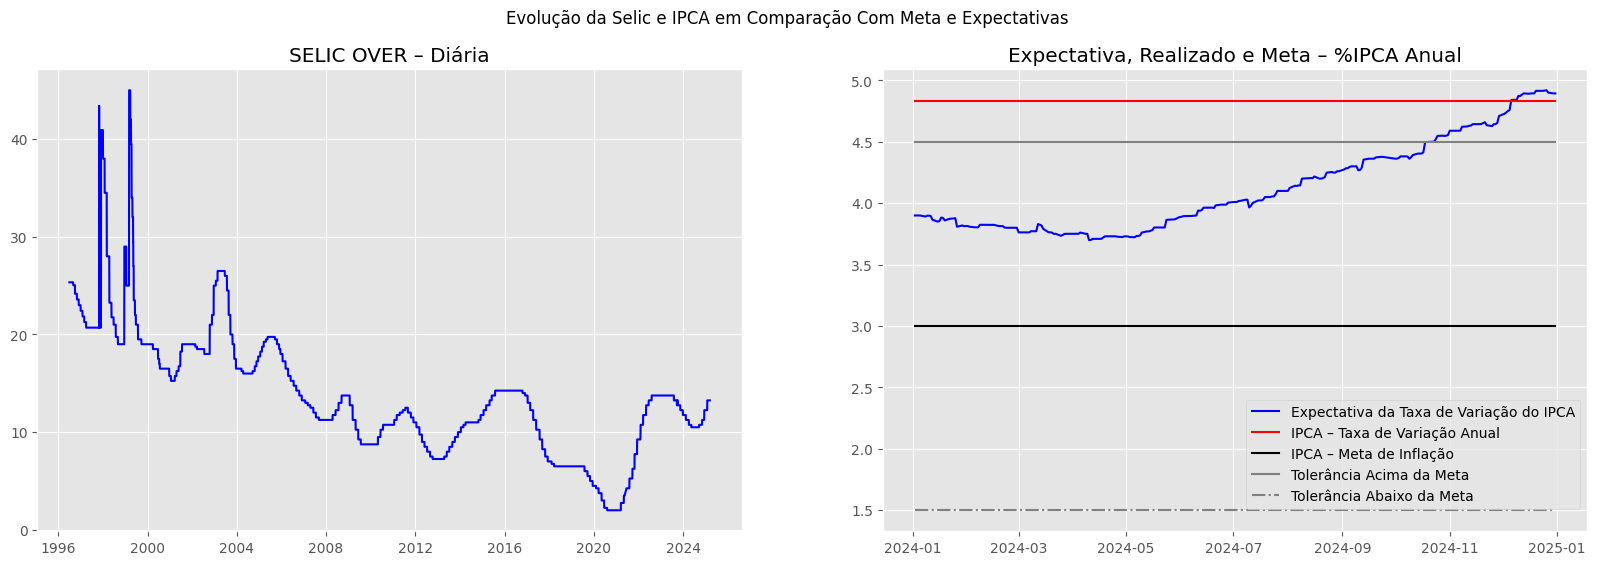

In [35]:
#PLOTANDO GRÁFICOS DA DINÂMICA DA SELIC E EXPECTATIVAS DE INFLAÇÃO NO ÚLTIMO ANO
#plotando o gráfico da selic over
plt.style.use("ggplot")
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(selic_diaria, linestyle='-', color="blue")
axs[0].set_title('SELIC OVER – Diária')

#plotando o gráfico das expectativas do FOCUS para o ipca em 2024 em comparação com o efetivo
#vetor ipca realizado no final de 2024
ipca_realizado = [] 
for i in range(0, len(exp_ipca)):
    ipca_realizado.append(ipca_anual[ipca_anual.index =='2024'].values[0][0])
ipca_realizado = pd.DataFrame(ipca_realizado)
ipca_realizado = ipca_realizado.set_index(exp_ipca.index)
ipca_realizado = ipca_realizado.loc[:'2024-12-31']

#vetor meta do ipca para 2024
#pela Resolução CMN nº 4.918, a meta para 2024 era de 3%, com um intevalo de tolerância de 1,50 - 4,50 por cento

ipca_meta = pd.DataFrame()
ipca_meta['BANDA_MENOR'] = [1.5 for i in range(0, len(exp_ipca))]
ipca_meta['META'] = [3  for i in range(0, len(exp_ipca))]
ipca_meta['BANDA_MAIOR'] = [4.5  for i in range(0, len(exp_ipca))]
ipca_meta = ipca_meta.set_index(exp_ipca.index)

axs[1].plot(exp_ipca, linestyle='-',label='Expectativa da Taxa de Variação do IPCA', color="blue")
axs[1].plot(ipca_realizado, linestyle='-',label='IPCA – Taxa de Variação Anual', color="red")
axs[1].plot(ipca_meta['META'], linestyle='-',label='IPCA – Meta de Inflação', color="black")
axs[1].plot(ipca_meta['BANDA_MAIOR'], linestyle='-',label='Tolerância Acima da Meta', color="gray")
axs[1].plot(ipca_meta['BANDA_MENOR'], linestyle='-.',label='Tolerância Abaixo da Meta', color="gray")

axs[1].set_title('Expectativa, Realizado e Meta – %IPCA Anual')
axs[1].legend(loc='upper right', bbox_to_anchor=(1, 0.3))

plt.suptitle("Evolução da Selic e IPCA em Comparação Com Meta e Expectativas")

plt.show()

In [ ]:
'''RESULTADOS PARA A PERGUNTA 2 Cálculo do Multiplicador Monetário no Brasil'''

In [36]:
#pegando os componentes do multiplicador monetário

componentes_k = pd.DataFrame()
#Comportamento monetário - Comportamento do público - C

componentes_k['C'] = sgs.get({'Comportamento monetário': 7530 }, start='2002-02-01')

#Comportamento monetário - Comportamento do público - D
componentes_k['D'] = sgs.get({'Comportamento monetário': 7531 }, start='2002-02-01')

#Comportamento monetário - Comportamento dos bancos - R1
componentes_k['R1'] = sgs.get({'BM': 7532 }, start='2002-02-01')

#Comportamento monetário - Comportamento dos bancos - R2
componentes_k['R2'] = sgs.get({'BM': 7533 }, start='2002-02-01')

In [39]:
#calculando o multiplicador monetário
componentes_k['K'] = round(1/(componentes_k['C'] + componentes_k['D']*(componentes_k['R1'] + componentes_k['R2'])), 3)

#calculando estatísticas descritivas do multiplicador monetário
estatisticas_k = pd.DataFrame()
estatisticas_k['Multiplicador Monetário'] = componentes_k['K'].describe()
estatisticas_k

,Multiplicador Monetário
count,276.000000
mean,1.435616
std,0.069093
min,1.253000
25%,1.373750
50%,1.449000
75%,1.489000
max,1.589000


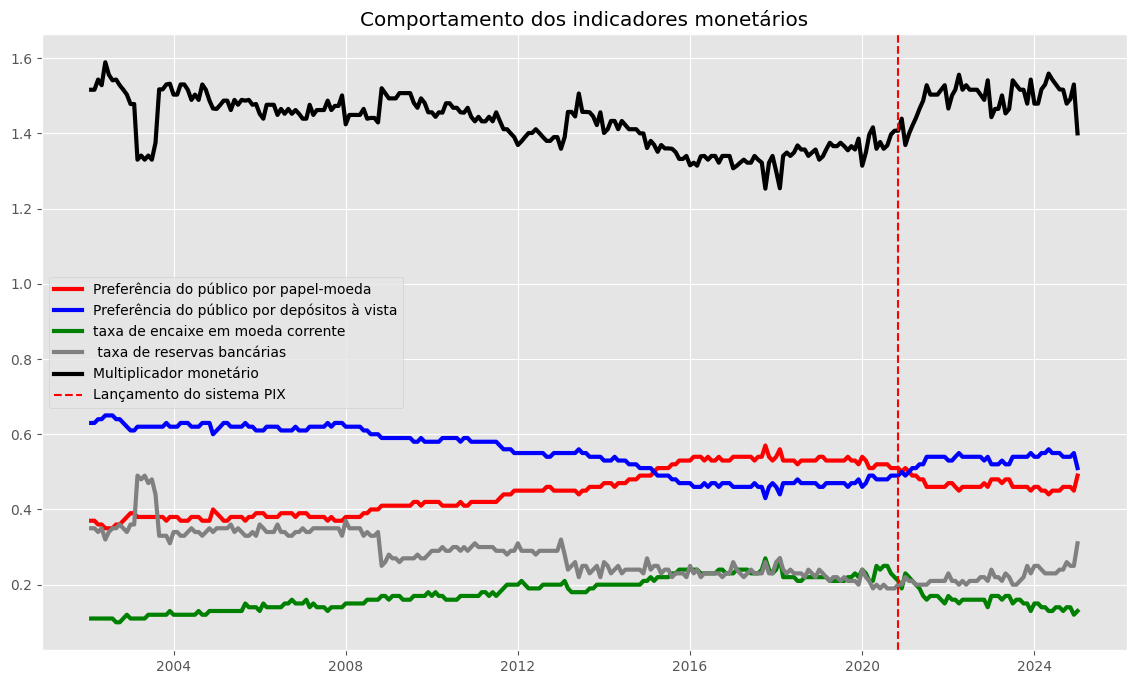

In [40]:
#plotando gráfico do multiplicador monetário e seus componentes
nomes_componentes_k = {'C':'Preferência do público por papel-moeda',
                        'D': 'Preferência do público por depósitos à vista',
                        'R1': 'taxa de encaixe em moeda corrente',
                        'R2':' taxa de reservas bancárias',
                        'K':'Multiplicador monetário'}
cor_componentes_k = {'C':'red',
                        'D': 'blue',
                        'R1': 'green',
                        'R2':'gray',
                        'K':'black'}
plt.style.use("ggplot")
plt.figure(figsize=(14,8))
for c in componentes_k:
    if c != 'media': 
        plt.plot(componentes_k[c], linestyle='-',label=nomes_componentes_k[c], color=cor_componentes_k[c], lw=3)

#Novembro de 2020 - data de lançamento do sistema PIX
plt.axvline(pd.to_datetime('2020-11-01'), color='red', linestyle='--', label='Lançamento do sistema PIX')
plt.legend()
plt.title('Comportamento dos indicadores monetários')
plt.show()

In [42]:
#pegando os dados do depósito compulsório
#Base monetária ampliada - Depósitos compulsórios em espécie (saldo em final de período)
compulsorio =  sgs.get({'Base monetária ampliada': 1828 }, start='2002-02-01')


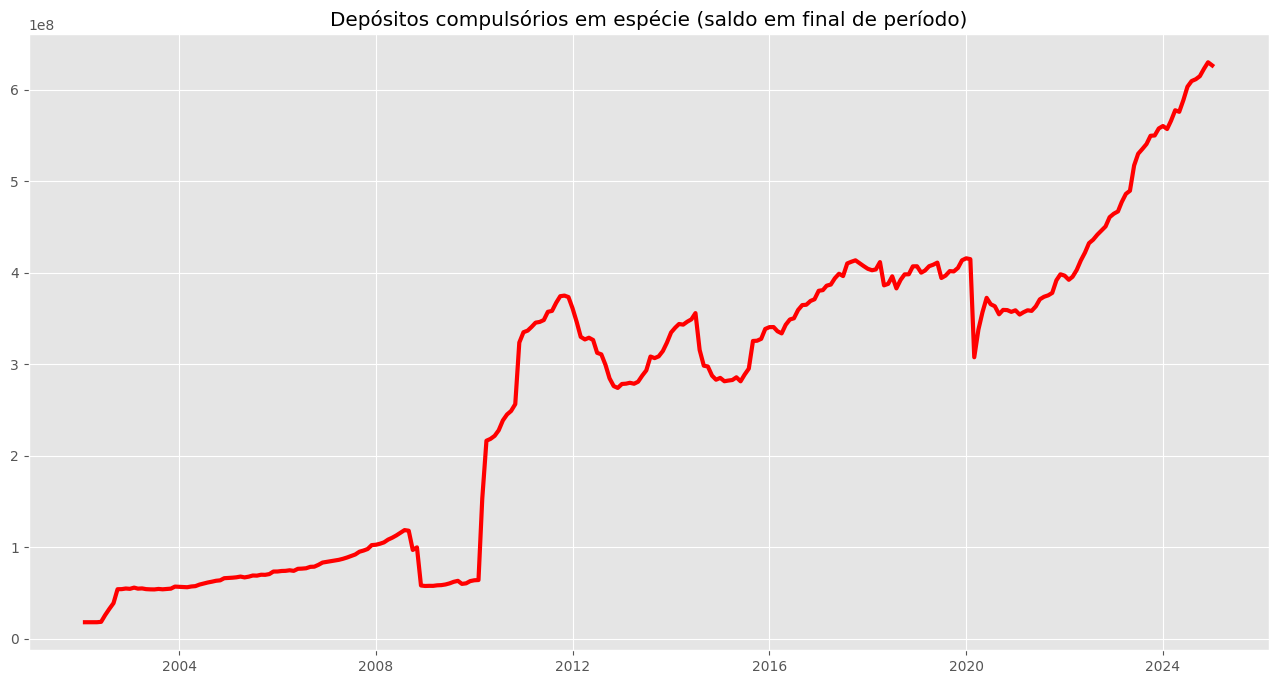

In [43]:
#plotando gráfico da evolução do depósito compulsório
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(compulsorio['Base monetária ampliada'], linestyle='-', color="red", lw=3)
plt.title('Depósitos compulsórios em espécie (saldo em final de período)')
plt.show()

In [44]:
'''RESULTADOS PARA A PERGUNTA 3 Impactos da Política Monetária sobre o Mercado de Capitais'''

'RESULTADOS PARA A PERGUNTA 3 Impactos da Política Monetária sobre o Mercado de Capitais'

In [45]:
#pegando os dados diários do ibovespa
ticker = yf.Ticker('^BVSP')
bovespa = ticker.history(interval='1d', start='2000-01-01', end='2025-03-01')

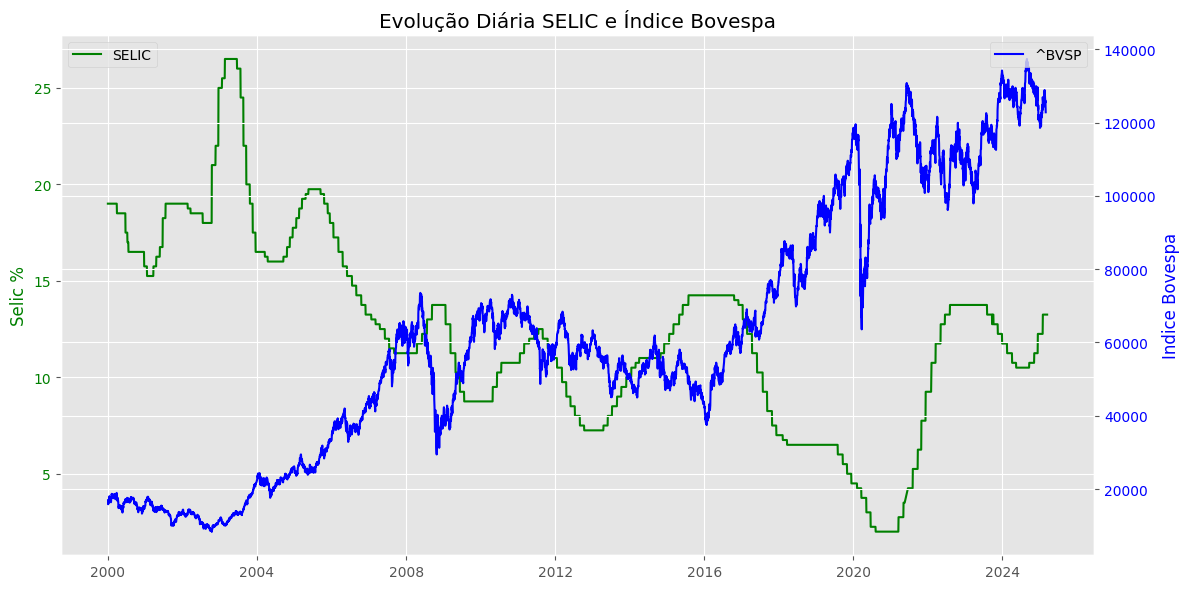

In [46]:
#Plotando o gráfico da evolução do ibovespa (fechamento) em relação à taxa SELIC
fig, ax1 = plt.subplots(figsize=(12, 6))

# eixo esquerdo
ax1.plot(selic_diaria.loc['2000-01-01':], color='green', linestyle='-', label='SELIC')
ax1.set_ylabel('Selic %', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Criando o segundo eixo (direito)
ax2 = ax1.twinx()

# eixo direito
ax2.plot(bovespa['Close'], color='blue', label='^BVSP')
ax2.set_ylabel('Indice Bovespa', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Evolução Diária SELIC e Índice Bovespa')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [47]:
#pegando os dados anuais para fazer a regressão e analisar a correlação entre as variáveis

#indice anual bovespa
est_bvsp_selic = bovespa['Close'].copy().resample('YE').last()
est_bvsp_selic.index = est_bvsp_selic.index.strftime('%Y')
est_bvsp_selic = pd.DataFrame(est_bvsp_selic)
est_bvsp_selic.columns = ['^BVSP']

#selic anual
selic_anual = selic_diaria.loc['2000-01-01':].copy().resample('YE').last()
selic_anual.index = selic_anual.index.strftime('%Y')
est_bvsp_selic['SELIC'] = selic_anual
est_bvsp_selic

,^BVSP,SELIC
Date,,
2000,15259.0,15.75
2001,13578.0,19.00
2002,11268.0,25.00
2003,22236.0,16.50
2004,26196.0,17.75
2005,33456.0,18.00
2006,44474.0,13.25
2007,63886.0,11.25
2008,37550.0,13.75


In [48]:
#estatísticas da regressão
X_sm = sm.add_constant(est_bvsp_selic['SELIC'])

resultados = sm.OLS(est_bvsp_selic['^BVSP'], X_sm).fit()

resultados.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ^BVSP   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     18.06
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           0.000280
Time:                        11:55:06   Log-Likelihood:                -303.05
No. Observations:                  26   AIC:                             610.1
Df Residuals:                      24   BIC:                             612.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.28e+05   1.56e+04      8.193      0.000    9.57e+04     1.6e+05
SELIC      -5052.5293   1188.981     -4.249      0.000   -7506.465   -2598.594
==============================================================================
Omnibus:                        7.932   Durbin-Watson:                   0.292
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.658
Skew:                           1.228   Prob(JB):                       0.0358
Kurtosis:                       3.335   Cond. No.                         36.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

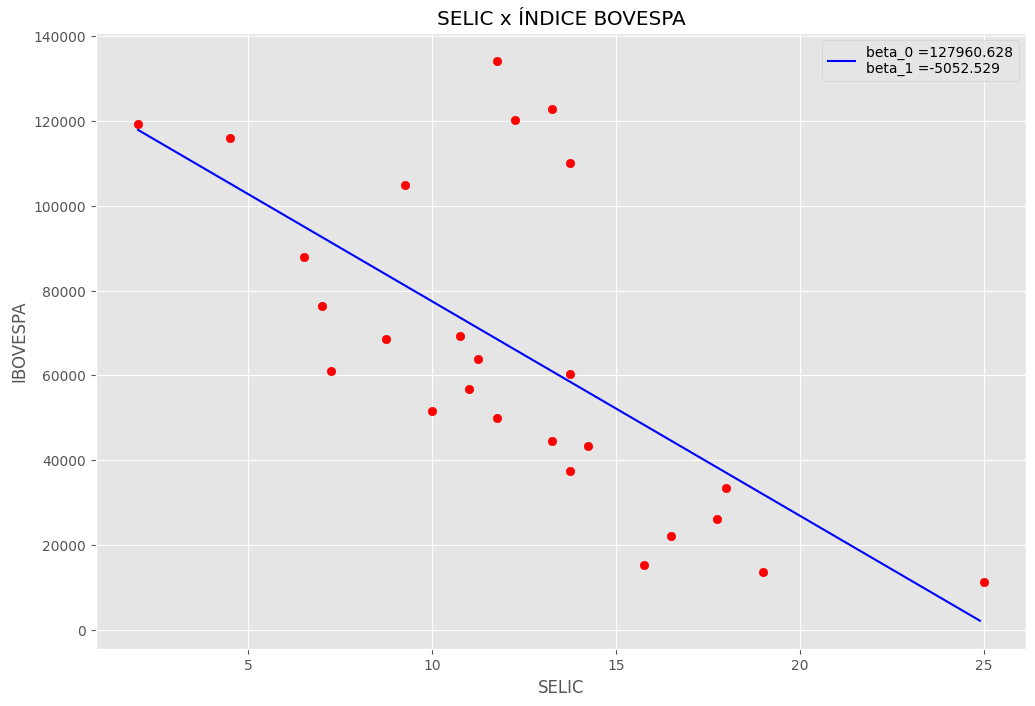

In [49]:
#criando vetores dos valores da regressão
betas = [resultados.params['const'], resultados.params['SELIC']]
x = np.arange(est_bvsp_selic['SELIC'].min(), est_bvsp_selic['SELIC'].max(), 0.1)
y = betas[0] + betas[1]*x
legenda= 'beta_0 =' + str(round(betas[0],3))+'\nbeta_1 ='+str(round(betas[1],3))

#plotando gráfico com regressão:
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.plot(x, y, color='blue', linestyle='-', linewidth = 1.5, label=legenda) 
plt.scatter(est_bvsp_selic['SELIC'], est_bvsp_selic['^BVSP'], color="r")
plt.xlabel('SELIC')
plt.ylabel('IBOVESPA')
plt.title('SELIC x ÍNDICE BOVESPA')
plt.legend()
plt.show()

In [50]:
#pegando os dados para análise da evolução das operações de crédito
#CREDITO A PESSOA FÍSICA
nome_credito_pf = "Operações de crédito - concessões - pessoa física"
credito_pf = serie_variavel('Operações de crédito', nome_credito_pf, "VALUE (R$)")

#CREDITO A PESSOA JURÍDICA
nome_credito_pj = "Operações de crédito - concessões - pessoa jurídica"
credito_pj = serie_variavel('Operações de crédito', nome_credito_pj, "VALUE (R$)")

#CREDITO TOTAL
nome_credito = "Operações de crédito - concessões - total"
credito = serie_variavel('Operações de crédito', nome_credito, "VALUE (R$)")

#INDICE IPCA
nome_ipca_indice = "IPCA - geral - índice (dez. 1993 = 100)"
ipca_indice = serie_variavel('IPCA',nome_ipca_indice,"VALUE (-)")

In [51]:
#corrigindo pelo ipca
credito_pf =  credito_pf.copy().merge(ipca_indice, on="DATE")
credito_pf['REAL'] = 100*credito_pf['VALUE (R$)'] / credito_pf['VALUE (-)']

credito_pj =  credito_pj.copy().merge(ipca_indice, on="DATE")
credito_pj['REAL'] = 100*credito_pj['VALUE (R$)'] / credito_pj['VALUE (-)']

credito =  credito.copy().merge(ipca_indice, on="DATE")
credito['REAL'] = 100*credito['VALUE (R$)'] /  credito['VALUE (-)']

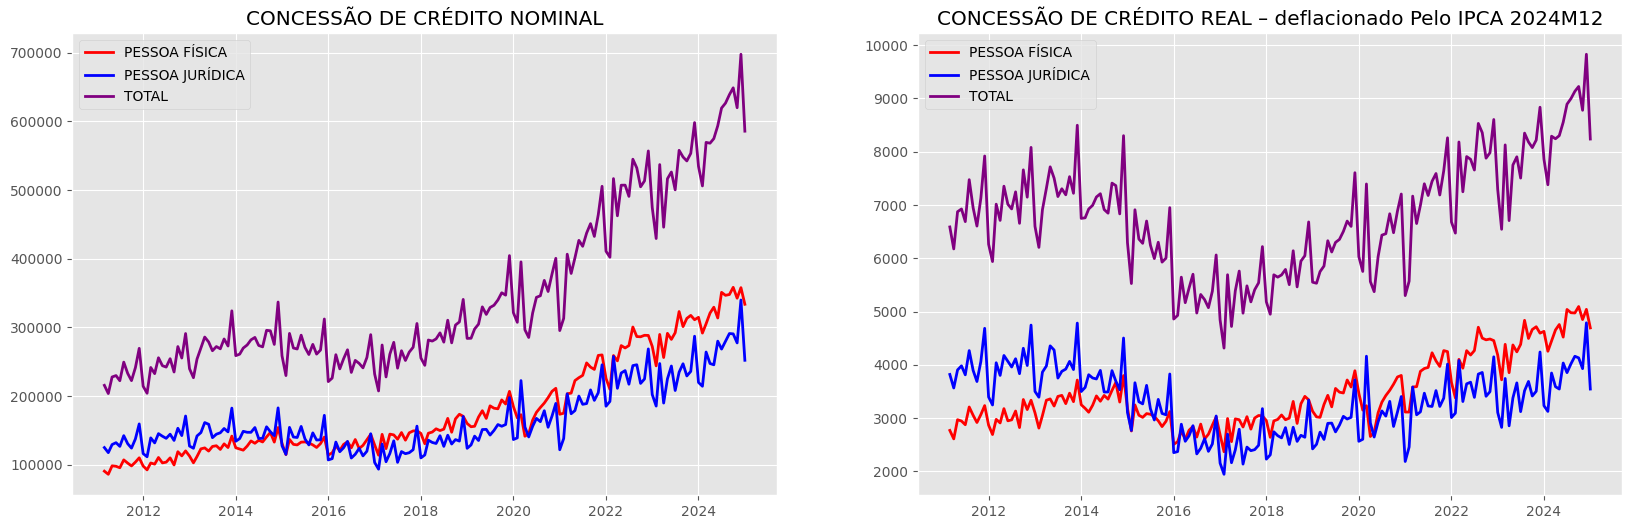

In [52]:
#Plotando os gráficos de concessão de crédito
plt.style.use("ggplot")

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

#concessão de crédito nominal
axs[0].plot(credito_pf['VALUE (R$)'], linestyle='-', color="red", lw=2, label='PESSOA FÍSICA')
axs[0].plot(credito_pj['VALUE (R$)'], linestyle='-', color="blue", lw=2, label='PESSOA JURÍDICA')
axs[0].plot(credito['VALUE (R$)'], linestyle='-', color="purple", lw=2, label='TOTAL')
axs[0].legend()
axs[0].set_title('CONCESSÃO DE CRÉDITO NOMINAL')

#concessão de crédito real
axs[1].plot(credito_pf['REAL'], linestyle='-', color="red", lw=2, label='PESSOA FÍSICA')
axs[1].plot(credito_pj['REAL'], linestyle='-', color="blue", lw=2, label='PESSOA JURÍDICA')
axs[1].plot(credito['REAL'], linestyle='-', color="purple", lw=2, label='TOTAL')
axs[1].legend()
axs[1].set_title('CONCESSÃO DE CRÉDITO REAL – deflacionado Pelo IPCA 2024M12')

plt.show()

In [53]:
#Pegando componentes do crédito para pessoa jurídica
#CONCESSÃO DE CRÉDITO PARA PJ – RECURSOS LIVRES
nome_credito_pj_rl = 'Operações de crédito - concessões de crédito - recursos livres - pessoa jurídica'
credito_pj_rl = serie_variavel('Operações de crédito', nome_credito_pj_rl, "VALUE (R$)")

#CONCESSÃO DE CRÉDITO PARA PJ – RECURSOS DIRECIONADOS
nome_credito_pj_rd = 'Operações de crédito - concessões - recursos direcionados - pessoa jurídica'
credito_pj_rd = serie_variavel('Operações de crédito', nome_credito_pj_rd, "VALUE (R$)")

In [54]:
#pegando dados do indicador de custo de crédito
icc = pd.DataFrame()
#Indicador de Custo do Crédito - ICC - Pessoas físicas - Total
icc['PJ_TOTAL'] = sgs.get({'ICC': 25353 }, start='2010-02-01')

#Indicador de Custo do Crédito - ICC - Recursos livres - Pessoas jurídicas - Total
icc['PJ_RL'] = sgs.get({'ICC': 25355 }, start='2010-02-01')

#Indicador de Custo do Crédito - ICC - Recursos direcionados - Pessoas jurídicas - Total
icc['PJ_RD'] = sgs.get({'ICC': 25358 }, start='2010-02-01')

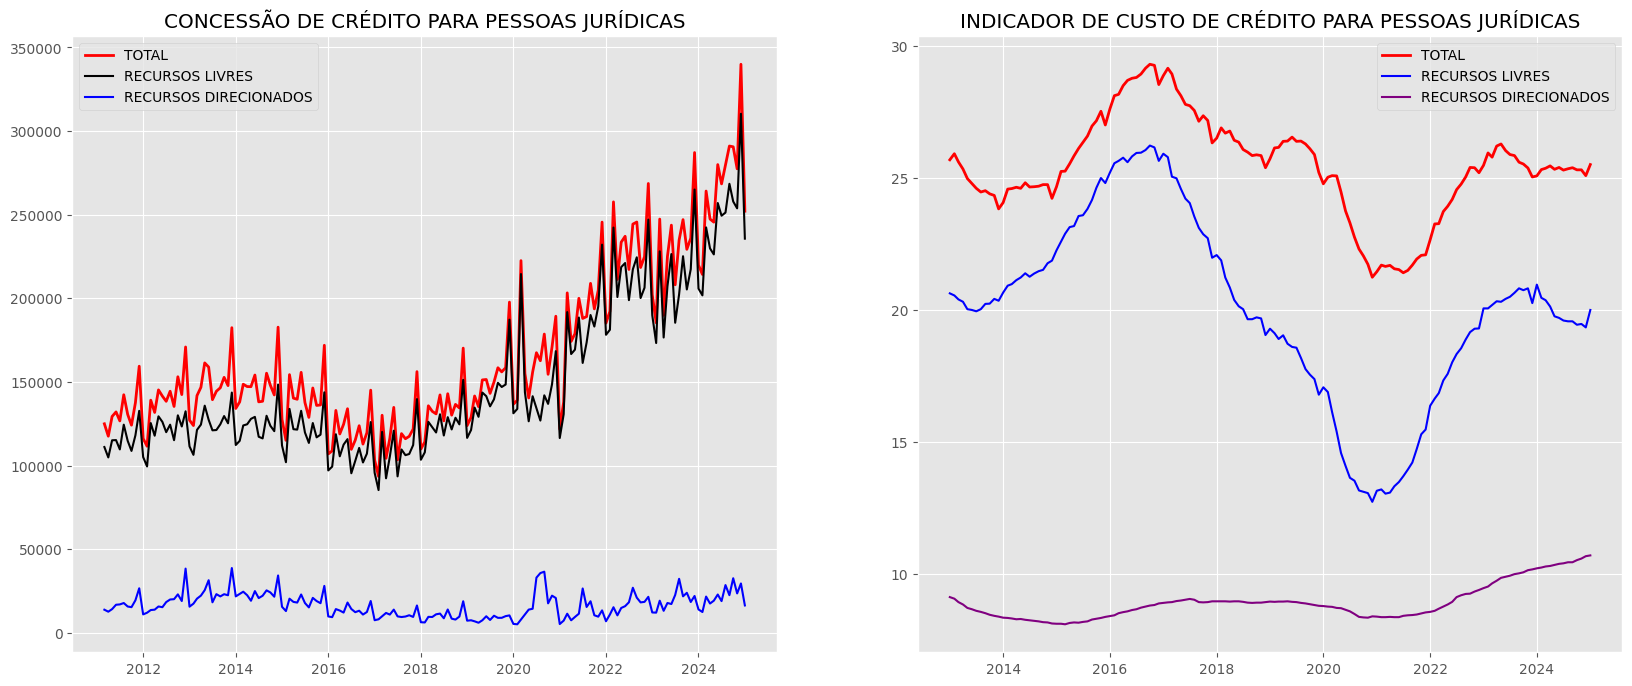

In [55]:
#Plotando gráficos da evolução da concessão de crédito para pessoa jurídica e indicador de custo de crédito
plt.style.use("ggplot")

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

#CONCESSÃO DE CRÉDITO PARA PESSOA JURÍDICA
axs[0].plot(credito_pj['VALUE (R$)'], linestyle='-', color="red", lw=2, label='TOTAL')
axs[0].plot(credito_pj_rl['VALUE (R$)'], linestyle='-', color="black", lw=1.5, label='RECURSOS LIVRES')
axs[0].plot(credito_pj_rd['VALUE (R$)'], linestyle='-', color="blue", lw=1.5, label='RECURSOS DIRECIONADOS')
axs[0].legend()
axs[0].set_title('CONCESSÃO DE CRÉDITO PARA PESSOAS JURÍDICAS')

#ICC PARA PESSOA JURÍDICA
axs[1].plot(icc['PJ_TOTAL'], linestyle='-', color="red", lw=2, label='TOTAL')
axs[1].plot(icc['PJ_RL'], linestyle='-', color="blue", lw=1.5, label='RECURSOS LIVRES')
axs[1].plot(icc['PJ_RD'], linestyle='-', color="purple", lw=1.5, label='RECURSOS DIRECIONADOS')
axs[1].legend()
axs[1].set_title('INDICADOR DE CUSTO DE CRÉDITO PARA PESSOAS JURÍDICAS')

plt.show()